# NEU502b Analysis: Signal Corruption

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from scripts.utilities import read_gifti
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
func_dir = 'preproc/fmriprep'
subjects = ['sub-01','sub-02']
tasks = ['visualbreathhold', 'visualhyperventilate']
spaces = ['fsaverage5.L','fsaverage5.R']

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 1: CompCor First Levels 

In [2]:
from scripts.prewhitening import prewhiten_data
from scripts.permutations import permutation_testing
from scripts.utilities import mask_insert
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Analysis parameters.
n_perm = False 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for task in tasks:
    
    ## Prepare save-directory.
    out_dir = os.path.join('first_levels', task)
    if not os.path.isdir(out_dir): os.makedirs(out_dir)
    
    for subj in subjects:

        for space in spaces:

            if not n_perm: break

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load task regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_events.txt' %(subj,task))
            events = np.loadtxt(f)
            if events.ndim == 1: events = events.reshape(-1,1)
            _, n_task = events.shape

            ## Load motion regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_motion.txt' %(subj,task))
            motion = np.loadtxt(f)
            if motion.ndim == 1: motion = motion.reshape(-1,1)
                
            ## Load compcor regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_compcor.txt' %(subj,task))
            compcor = np.loadtxt(f)
            if compcor.ndim == 1: compcor = compcor.reshape(-1,1)
                
            ## Load task data.
            f = os.path.join('first_levels',task,'%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Remove null vertices. 
            data, mask = npz['psc'], npz['mask']
            Y = data[:,mask]

            ## Append intercept to nuisance regressors.
            nuisance = np.concatenate([motion, compcor], axis=-1)
            nuisance = np.concatenate([np.ones([nuisance.shape[0], 1]), nuisance], axis=-1)            

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Prewhiten data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Construct design matrix.
            X = np.concatenate([events, nuisance], axis=-1)

            ## Prewhiten data (see script for details).
            WY, WX = prewhiten_data(Y, X)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### First-level regression.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Permutation testing (see script for details.)
            B, F, p = permutation_testing(WY, WX, n_task, n_perm)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Save results.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Save.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.compcor.npz' %(subj, task, space))
            np.savez_compressed(f, B=mask_insert(B,mask), F=mask_insert(F,mask), 
                                p=mask_insert(p,mask))

print('Done.')

Done.


### Generate Surface Maps

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Significance threshold.
alpha = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Redefine threshold.
threshold = -np.log10(alpha)

for task in tasks:

    ## Define save-directory.
    out_dir = os.path.join('first_levels', task)
    
    for subj in subjects:

        for space in spaces:

            ## Load data.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.compcor.npz' %(subj, task, space))
            npz = np.load(f)

            ## Extract PSC and p-vals corresponding to checkerboard condition.
            psc, pvals = npz['B'][0], npz['p'][0]

            ## Threshold PSC by significance.
            psc[np.abs(pvals) < threshold] = 0

            ## Convert to NIFTI image.
            obj = nib.Nifti1Image(psc.reshape(-1,1,1,1), np.identity(4))

            ## Save.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.compcor.nii.gz' %(subj, task, space))
            nib.save(obj, f)

### Contrast PSC across conditions

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/media/szoro/SZORO1/pni-courses/neu502b/fmri/scripts/prewhitening.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B_ols, _, _, _ = np.linalg.lstsq(X, Y)


sub-01 Con vs. Breath: F = 13.058, p = 0.000
sub-01 Con vs. Hyper: F = 17.009, p = 0.000
sub-02 Con vs. Breath: F = 73.083, p = 0.000
sub-02 Con vs. Hyper: F = 6.032, p = 0.014


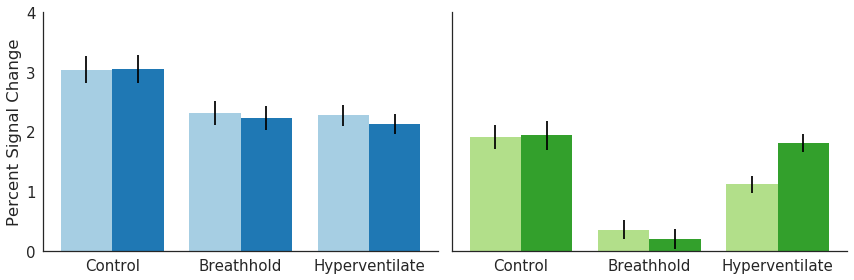

In [4]:
from mne import read_label
from scipy.linalg import block_diag
from statsmodels.api import OLS

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
palette = sns.color_palette("Paired", n_colors=4).as_hex()
palette = np.array(palette).reshape(2,2)

## Define label directory.
label_dir = 'first_levels/labels'

for ax, subj, colors in zip(axes, subjects, palette):
    
    WX, WY = [], []
    
    for task in ['visualcontrol','visualbreathhold', 'visualhyperventilate']:
        
        data_dir = 'first_levels/%s' %task
        
        for space in spaces:

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load task regressors.
            f = os.path.join(data_dir,'%s_task-%s_events.txt' %(subj,task))
            events = np.loadtxt(f)
            if events.ndim == 1: events = events.reshape(-1,1)
            _, n_task = events.shape

            ## Load motion regressors.
            f = os.path.join(data_dir,'%s_task-%s_motion.txt' %(subj,task))
            motion = np.loadtxt(f)
            if motion.ndim == 1: motion = motion.reshape(-1,1)
                
            ## Load compcor regressors.
            f = os.path.join(data_dir,'%s_task-%s_compcor.txt' %(subj,task))
            compcor = np.loadtxt(f)
            if compcor.ndim == 1: compcor = compcor.reshape(-1,1)
                
            ## Load task data.
            f = os.path.join(data_dir,'%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Load label.
            hemi = 'lh' if space == 'fsaverage5.L' else 'rh'
            f = os.path.join(label_dir, '%s_V1-%s.label' %(subj, hemi))
            label = read_label(f)

            ## Mask data by label.
            y = npz['psc'][:,label.vertices].mean(axis=-1).reshape(-1,1)

            ## Append intercept to nuisance regressors.
            nuisance = np.concatenate([motion, compcor], axis=-1)
            nuisance = np.concatenate([np.ones([nuisance.shape[0], 1]), nuisance], axis=-1)
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Prewhiten data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Construct design matrix.
            X = np.concatenate([events, nuisance], axis=-1)

            ## Prewhiten data (see script for details).
            wy, wX = prewhiten_data(y, X)
            wX, wy = wX.squeeze(), wy.squeeze()
            
            ## Append.
            WX.append(wX)
            WY.append(wy)
                        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### First level regression.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Identify checkerboard contrast.
    indices = np.insert(np.cumsum([wx.shape[-1] for wx in WX])[:-1], 0, 0)

    ## Perform OLS.
    WX = block_diag(*WX)
    WY = np.concatenate(WY)
    fit = OLS(WY, WX).fit()

    ## Perform contrasts (Control vs. Breathhold).
    contrast = [1,1,-1,-1,0,0]
    r_matrix = np.zeros_like(fit.params)
    r_matrix[indices] = contrast
    f_test = fit.f_test(r_matrix)
    print('%s Con vs. Breath: F = %0.3f, p = %0.3f' %(subj, f_test.fvalue, f_test.pvalue))

    ## Perform contrasts (Control vs. Hyperventilate).
    contrast = [1,1,0,0,-1,-1]
    r_matrix = np.zeros_like(fit.params)
    r_matrix[indices] = contrast
    f_test = fit.f_test(r_matrix)
    print('%s Con vs. Hyper: F = %0.3f, p = %0.3f' %(subj, f_test.fvalue, f_test.pvalue))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Barplots.
    x = [0,1,2.5,3.5,5,6]
    y = fit.params[indices]
    yerr = (fit.params / fit.tvalues)[indices]
    ax.bar(x, y, width=1, yerr=yerr, color=colors)
    ax.set(xticks=[0.5,3,5.5], xticklabels=['Control','Breathhold','Hyperventilate'])
    
## Add info to plot.
axes[0].set(yticks=np.arange(5), ylabel='Percent Signal Change')
    
sns.despine()
plt.tight_layout()

## Step 2: Artifact FIR First Levels 

In [5]:
from scripts.prewhitening import prewhiten_data
from scripts.permutations import permutation_testing
from scripts.utilities import mask_insert
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Analysis parameters.
n_perm = False 

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for task in tasks:
    
    ## Prepare save-directory.
    out_dir = os.path.join('first_levels', task)
    if not os.path.isdir(out_dir): os.makedirs(out_dir)
    
    for subj in subjects:

        for space in spaces:

            if not n_perm: break

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load task regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_events.txt' %(subj,task))
            events = np.loadtxt(f)
            if events.ndim == 1: events = events.reshape(-1,1)
            _, n_task = events.shape

            ## Load motion regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_motion.txt' %(subj,task))
            motion = np.loadtxt(f)
            if motion.ndim == 1: motion = motion.reshape(-1,1)
                
            ## Load custom regressors.
            f = os.path.join('first_levels',task,'%s_task-%s_artifact.txt' %(subj,task))
            artifact = np.loadtxt(f)
            if artifact.ndim == 1: artifact = artifact.reshape(-1,1)
                
            ## Load task data.
            f = os.path.join('first_levels',task,'%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Remove null vertices. 
            data, mask = npz['psc'], npz['mask']
            Y = data[:,mask]

            ## Append intercept to nuisance regressors.
            nuisance = np.concatenate([motion, artifact], axis=-1)
            nuisance = np.concatenate([np.ones([nuisance.shape[0], 1]), nuisance], axis=-1)
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Prewhiten data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Construct design matrix.
            X = np.concatenate([events, nuisance], axis=-1)

            ## Prewhiten data (see script for details).
            WY, WX = prewhiten_data(Y, X)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### First-level regression.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Permutation testing (see script for details.)
            B, F, p = permutation_testing(WY, WX, n_task, n_perm)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Save results.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Save.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.artifact.npz' %(subj, task, space))
            np.savez_compressed(f, B=mask_insert(B,mask), F=mask_insert(F,mask), 
                                p=mask_insert(p,mask))

print('Done.')

Done.


### Generate Surface Maps

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Significance threshold.
alpha = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Redefine threshold.
threshold = -np.log10(alpha)

for task in tasks:

    ## Define save-directory.
    out_dir = os.path.join('first_levels', task)
    
    for subj in subjects:

        for space in spaces:

            ## Load data.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.artifact.npz' %(subj, task, space))
            npz = np.load(f)

            ## Extract PSC and p-vals corresponding to checkerboard condition.
            psc, pvals = npz['B'][0], npz['p'][0]

            ## Threshold PSC by significance.
            psc[np.abs(pvals) < threshold] = 0

            ## Convert to NIFTI image.
            obj = nib.Nifti1Image(psc.reshape(-1,1,1,1), np.identity(4))

            ## Save.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.artifact.nii.gz' %(subj, task, space))
            nib.save(obj, f)

### Contrast PSC across conditions

/media/szoro/SZORO1/pni-courses/neu502b/fmri/scripts/prewhitening.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B_ols, _, _, _ = np.linalg.lstsq(X, Y)


sub-01 Con vs. Breath: F = 9.043, p = 0.003
sub-01 Con vs. Hyper: F = 6.970, p = 0.008
sub-02 Con vs. Breath: F = 64.175, p = 0.000
sub-02 Con vs. Hyper: F = 28.458, p = 0.000


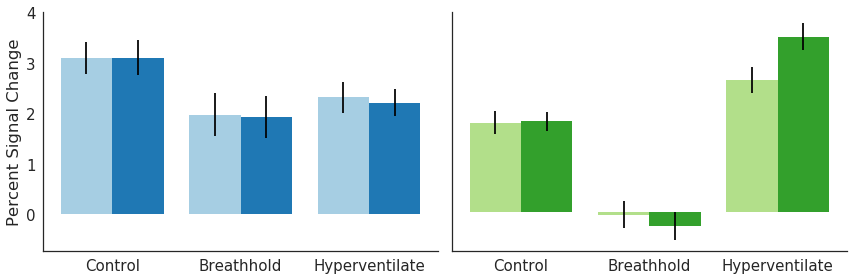

In [7]:
from mne import read_label
from scipy.linalg import block_diag
from statsmodels.api import OLS

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
palette = sns.color_palette("Paired", n_colors=4).as_hex()
palette = np.array(palette).reshape(2,2)

## Define label directory.
label_dir = 'first_levels/labels'

for ax, subj, colors in zip(axes, subjects, palette):
    
    WX, WY = [], []
    
    for task in ['visualcontrol','visualbreathhold', 'visualhyperventilate']:
        
        data_dir = 'first_levels/%s' %task
        
        for space in spaces:

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load task regressors.
            f = os.path.join(data_dir,'%s_task-%s_events.txt' %(subj,task))
            events = np.loadtxt(f)
            if events.ndim == 1: events = events.reshape(-1,1)
            _, n_task = events.shape

            ## Load motion regressors.
            f = os.path.join(data_dir,'%s_task-%s_motion.txt' %(subj,task))
            motion = np.loadtxt(f)
            if motion.ndim == 1: motion = motion.reshape(-1,1)
                
            ## Load custom regressors.
            if task != 'visualcontrol':
                f = os.path.join('first_levels',task,'%s_task-%s_artifact.txt' %(subj,task))
                artifact = np.loadtxt(f)
                if artifact.ndim == 1: artifact = artifact.reshape(-1,1)
                
            ## Load task data.
            f = os.path.join(data_dir,'%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Load label.
            hemi = 'lh' if space == 'fsaverage5.L' else 'rh'
            f = os.path.join(label_dir, '%s_V1-%s.label' %(subj, hemi))
            label = read_label(f)

            ## Mask data by label.
            y = npz['psc'][:,label.vertices].mean(axis=-1).reshape(-1,1)

            ## Append intercept to nuisance regressors.
            if task == 'visualcontrol':
                nuisance = motion.copy()
            else:
                nuisance = np.concatenate([motion, artifact], axis=-1)
            nuisance = np.concatenate([np.ones([nuisance.shape[0], 1]), nuisance], axis=-1)
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Prewhiten data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Construct design matrix.
            X = np.concatenate([events, nuisance], axis=-1)

            ## Prewhiten data (see script for details).
            wy, wX = prewhiten_data(y, X)
            wX, wy = wX.squeeze(), wy.squeeze()
            
            ## Append.
            WX.append(wX)
            WY.append(wy)
                        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### First level regression.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Identify checkerboard contrast.
    indices = np.insert(np.cumsum([wx.shape[-1] for wx in WX])[:-1], 0, 0)

    ## Perform OLS.
    WX = block_diag(*WX)
    WY = np.concatenate(WY)
    fit = OLS(WY, WX).fit()

    ## Perform contrasts (Control vs. Breathhold).
    contrast = [1,1,-1,-1,0,0]
    r_matrix = np.zeros_like(fit.params)
    r_matrix[indices] = contrast
    f_test = fit.f_test(r_matrix)
    print('%s Con vs. Breath: F = %0.3f, p = %0.3f' %(subj, f_test.fvalue, f_test.pvalue))

    ## Perform contrasts (Control vs. Hyperventilate).
    contrast = [1,1,0,0,-1,-1]
    r_matrix = np.zeros_like(fit.params)
    r_matrix[indices] = contrast
    f_test = fit.f_test(r_matrix)
    print('%s Con vs. Hyper: F = %0.3f, p = %0.3f' %(subj, f_test.fvalue, f_test.pvalue))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Barplots.
    x = [0,1,2.5,3.5,5,6]
    y = fit.params[indices]
    yerr = (fit.params / fit.tvalues)[indices]
    ax.bar(x, y, width=1, yerr=yerr, color=colors)
    ax.set(xticks=[0.5,3,5.5], xticklabels=['Control','Breathhold','Hyperventilate'])
    
## Add info to plot.
axes[0].set(yticks=np.arange(5), ylabel='Percent Signal Change')
    
sns.despine()
plt.tight_layout()